In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

colors_ = ["blue", "red", "green", "gray", "black"]

import pylib.mix as mix
import pylib.measurement as mse

9652
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

path_save_plots_ = "./tools/QSVT-angles/inversion/saved-plots/"
flag_save_ = False

In [11]:
# ------------------------------------------------------------------
# --- Create a test matrix ---
# ------------------------------------------------------------------
from numpy import linalg as LA

# --- Number of coefficients used for the estimation of the QSVT angles ---
Nc_ = 20

# --- Original matrix ---
n_ = 14
N = 1 << n_
x = np.linspace(-1.0, 1.0, N)
y = np.sin(x)
A_orig = np.diag(y)

# --- Normalized matrix ---
nonsparsity = 1  
rows_sum = np.zeros(N)
for ir in range(N):
    rows_sum[ir] = np.sqrt(np.sum(np.abs(A_orig[ir,:])**2))
coef_norm_H = np.max(rows_sum)

final_norm_of_H_ = nonsparsity
if coef_norm_H > 1:
    final_norm_of_H_ *= coef_norm_H
    
A = A_orig/final_norm_of_H_
print("\nNormalization factor: {:0.3e}".format(final_norm_of_H_))

# --- SIN parameters ---
alpha_k0 = - 1.0
alpha_k1 = np.abs(alpha_k0) * N/(N - 1)
print("   nx \t{:d}".format(n_))
print("   alpha_k0 \t{:0.12e}".format(alpha_k0))
print("   alpha_k1 \t{:0.12e}".format(alpha_k1))


Normalization factor: 1.000e+00
   nx 	14
   alpha_k0 	-1.000000000000e+00
   alpha_k1 	1.000061038882e+00


In [4]:
# ----------------------------------------------------------
# --- Compute the condition number ---
# ----------------------------------------------------------
evals, evecs = LA.eig(A)
kappa_ = np.max(np.abs(evals)) / np.min(np.abs(evals))
print("nx: \t{:d}".format(n_))
print("cond. number: {:0.1f}".format(kappa_))


nx: 	14
cond. number: 13785.8


In [13]:
# --------------------------------------------------------
# --- Scan condition number versus nx ---
# --------------------------------------------------------
def save_scan():
    nx_array = [   10,     11,     12,     13,      14]
    k__array = [860.8, 1722.5, 3445.8, 6892.5, 13785.8]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_sin_kappa_nx.dat", 
        nx_array, k__array
    )
    return


def save_max_rel_error():
    # k-qsvt:   861,             2000,       4000,      7000,      14000
    nx_array  = [       10,        11,         12,        13,        14]
    err_array = [5.379e-06, 1.412e-05,  2.123e-05, 3.401e-05, 5.159e-05]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_sin_err_nx.dat", 
        nx_array, np.log10(err_array)
    )
    return

# --------------------------------
save_scan()
save_max_rel_error()

write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_sin_kappa_nx.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_sin_err_nx.dat


Reading the file ../QuCF/simulations/matrix-inversion-sin//MI_n14_k14000_Nc20_OUTPUT.hdf5...
Name of the simulation is MI
Simulation has been performed  02-22-2024 11:27:53
nx: 14

QSVT kappa: 14000.0

max. relative err: 5.159e-05


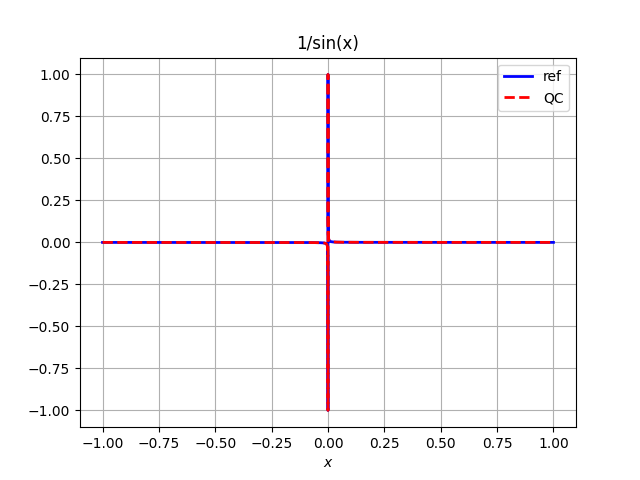

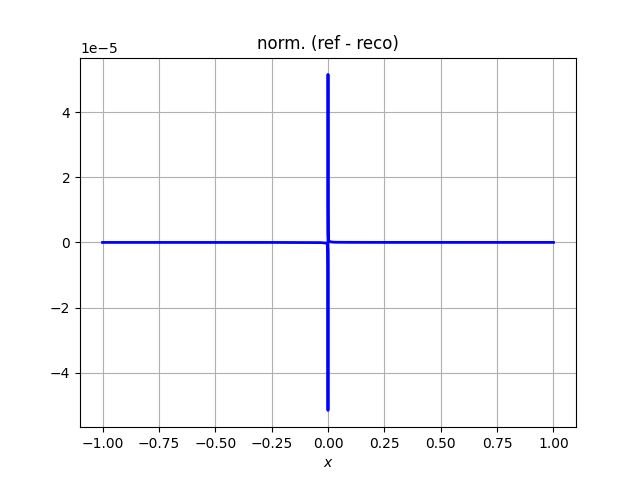

In [12]:
# -------------------------------------------------
# --- Matrix inversion ---
# -------------------------------------------------
mix.reload_module(mse)

# kappa_qsvt = 861.0
# kappa_qsvt = 1000.0
# kappa_qsvt = 2000.0
# kappa_qsvt = 4000.0
# kappa_qsvt = 7000.0
kappa_qsvt = 14000.0

# --- Reading QC data ---
path_data_ = "../QuCF/simulations/matrix-inversion-sin/"
pr_name_ = "MI_n{:d}_k{:d}_Nc{:d}".format(n_, int(kappa_qsvt), Nc_)

om = mse.MeasOracle__(True)
om.path_  = path_data_
om.pname_ = pr_name_
om.open()

# ---
print("nx: {:d}".format(n_))

# --- QSVT parameter ---
om.read_qsvt()
kappa_qc = om.dd_["qsvt_mi"]["par"]
if np.abs(kappa_qc - kappa_qsvt) > 1e-4:
    print()
    print("<<< ERROR: a wrong QSVT parameter.>>>")
    print()
del kappa_qsvt
print()
print("QSVT kappa: {:0.1f}".format(kappa_qc))

# --- QuCF data ---
om.set_zero_ancillae_work_states(0)
qc_data_all = om.get_var_x({}, "rs")
qc_data = qc_data_all.imag  # correct global phase;
qc_data *= 2**(n_/2.) * kappa_qc / om.dd_["qsvt_mi"]["rescaling_factor"]

# --- Reference data ---
ref_data = 1./y.real

# --- Normalize the signals ---
norm_ref = np.max(np.abs(ref_data))
ref_data /= norm_ref
qc_data /= norm_ref

# --- Relative error ---
norm_diff = ref_data - qc_data
max_rel_err = np.max(np.abs(norm_diff))
print()
print("max. relative err: {:0.3e}".format(max_rel_err))

# --- Plotting: comparison ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    x, ref_data, 
    color='b', linewidth = 2, linestyle='-',  
    label = "ref"
)
ax.plot(
    x, qc_data,
    color='r', linewidth = 2, linestyle='--',  
    label = "QC"
)
plt.xlabel('$x$')
plt.title("1/sin(x)")
ax.legend()
plt.grid(True)
plt.show()

# --- Plotting: error ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, norm_diff, color='b', linewidth = 2, linestyle='-')
plt.xlabel('$x$')
plt.title("norm. (ref - reco)")
plt.grid(True)
plt.show()

if flag_save_:
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_sin_ref.dat", 
        x, ref_data
    )
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_sin_reco.dat", 
        x, qc_data
    )
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_sin_err_x.dat", 
        x, norm_diff
    )